# Drafts

> Finished products are for decadent minds. *The Second foundation*

On models: First principles reasoning to nail the solution 



In [4]:
import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.datasets.samples_generator import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns

from scipy.stats.mstats import winsorize
sns.set()

c:\users\dfoga\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Older Feature engineering of Persons (camera tv) and Avg dayly revenues per person (12/09/2020)


Children 0.7 of Adults ADR (only room rate)

**Shall I do ADR adjusted by the number in the room/max available? 1 for adults, 0.7 for children. Do EDA for finding it out by TYPE and NUMBER OF PEOPLE INSIDE**



In [ ]:
""" OLD CODE CAN BE USEFUL FOR THE STRUCTURE """

"""def extend_adults(df):
    s = pd.DataFrame()
    for i in df.index:
        s = s.append([pd.DataFrame(data=[list(df.values[i])]*int(df['Adults'][i]))], ignore_index=True)
    s.columns = df.columns
    return s"""

# hotel['TimeArrival'] = hotel['TimeArrival'].apply(lambda x: x.strftime('%Y-%m-%d'))


In [ ]:
# Not Necessary to tackle inf values generated by XXXX
# hotel['Total ADR'] = np.where(hotel['Total ADR'] == np.inf, 0, hotel['Total ADR'])

In [ ]:
# ADR average as sum of child == adult
first = hotel['ADR']
hotel['Persons'] = hotel['Adults'] + hotel['Children'] 
# Avg per day (sum of all persons)
second = first + hotel['Additional Expenditures'] / hotel['Nights'] 
third = second / hotel['Persons']
third


# hotel['Persons Weighted'] = hotel['Adults'] + hotel['Children'] * 0.7

# Additional expenditures is for all in room, ADR is avg of the period among all the people in room calculated as XXXX
# Total AD Revenues is all revenues for that room, as daily avg of everybody
hotel['Total AD Revenues'] = hotel['ADR'] + hotel['Additional Expenditures'] / hotel['Nights']

# Number of physical persons per room (dataframe row) - Not Weighted 
hotel['Persons'] = hotel['Adults'] + hotel['Children'] 

# 
hotel['Total Daily Revenues'] = hotel['Total AD Revenues'] * hotel['Persons']

# 
hotel['Total Revenues'] = hotel['ADR'] * hotel['Nights'] + hotel['Additional Expenditures']

"""# This shouldn't be a problem at all
hotel['Total AD Revenues'] = np.where(hotel['Total AD Revenues'] == np.inf, 0, hotel['Total AD Revenues'])"""

In [ ]:
hotel['Assigned Room Type'].value_counts()
## 
# Weight of the Children with the Adult as baseline
hotel['Children Adj'] = hotel['Children'] * 0.7


# Number of persons per room (dataframe row) - Weighted with Children constituting 0.7
hotel['Persons Adj'] = hotel['Adults'] + hotel['Children Adj']

# Max Number of persons - Weighted and Not
hotel[['Adults', 'Children Adj', 'Persons Adj', 'Persons']].groupby(hotel['Assigned Room Type']).max()

# Max number of persons (weighted) by Room Type, 
# necesary for the calculation of the amount of revenues as share of the max available on that type of Room
# For Example Type F, Max is 4.10 and Adults is 4. It means that it can at max accomodate 2 Adults and 2 children
rooms_weights = hotel[['Adults', 'Children Adj', 'Persons Adj']].groupby(hotel['Assigned Room Type']).max()
rooms_weights

rooms = list(rooms_weights.index)
weights = list(rooms_weights['Persons Adj'])

# Dictionary, whose keys are the types of room and the value is the max capacity
dictionary_persons = dict(zip(rooms, weights))
hotel['Max capacity Room'] = hotel['Assigned Room Type']
hotel['Max capacity Room'] = hotel['Max capacity Room'].replace(to_replace=dictionary_persons)
hotel['Max capacity Room']

hotel['Assigned Room Type']


# Average (over the period) daily total revenue per person in the room adjusted per adult/child
# and by max capacity in the room
# Hence:
hotel['Persons Weighted'] = hotel['Adults'] + hotel['Children'] * 0.7
weighted_num_persons = hotel['Persons Weighted']/hotel['Max capacity Room']

# Since total AD Revenues are including all the persons, I want the weighted (adult or child) average revenue per person per day
# I should penalise if there are few persons inside the room compared as if there are close to max capacity?
hotel['AD Revenues Weighted'] = round(hotel['Total AD Revenues'] / (hotel['Persons Weighted'] /  weighted_num_persons), ndigits=2)
hotel['AD Revenues Weighted']




# This doesn't account for max capacity in the room, just the adj adults/children
# Final total revenues Weighted by the number of occupants ##compared to the max capacity of the room
hotel['Persons Weighted'] = hotel['Adults'] + hotel['Children'] * 0.7
hotel['Daily Revenues Weighted'] = round(hotel['Total AD Revenues'] / hotel['Persons Weighted'], ndigits=2)
hotel['Daily Revenues Weighted']

# EDA

In [1]:
# hotel.isin([np.inf]).any()


## Outliers

In [ ]:
## With regression

# evaluate model performance with outliers removed using isolation forest
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error

df = hotel.copy()
# retrieve the array
data = df.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

In [ ]:
## Unclear

iso = IsolationForest(contamination=0.1)
rat = hotel['Customer Satisfaction Rating']
rat = rat.to_numpy()
rat = np.reshape(rat, (-1, 1)) 
yhat = iso.fit_predict(rat)

# select all rows that are not outliers
mask = yhat != -1
rat, y_train = X_train[mask, :], y_train[mask]

In [ ]:
## Winsorizing by DF

""" NOT SURE WHAT TO DO WITH THIS """
print(np.percentile(hotel['Total ADR'], 100))
print(np.percentile(hotel['Total ADR'], 100))
winsor = winsorize(hotel['Total ADR'], 0.99)
len(winsor)


for i in range(0, 20, 1):
    print(str((98)+i/10) + ' percentile:')
    print(np.percentile(hotel['AD Revenues Weighted'], 98 +i/10))

    
# Too many entries for being winsorized actually. THINK
hotel['testing'] = np.where(hotel['AD Revenues Weighted'] > np.percentile(hotel['AD Revenues Weighted'], 99.9), 
                            np.percentile(hotel['AD Revenues Weighted'], 99.9),
                            hotel['AD Revenues Weighted'])


plt.figure(figsize=(8, 8))
hotel['testing'].hist(bins=90)


len(hotel['testing'].loc[hotel['testing']>35000])


""" THIS DROPS OFFICIALLY """
# hotel = hotel.drop(hotel.loc[hotel['AD Revenues Weighted']>35000].index, axis=0)



In [ ]:
from scipy import stats

"""z = np.abs(stats.zscore(hotel['Customer Satisfaction Rating']))
threshold = 3
print(np.where(z > threshold))"""


threshold = 3
outlier = [] 
mean_rat = np.mean(data) 
std_rat = np.std(data) 
for i in data: 
    z = (i-mean_rat)/std_rat 
    if z > threshold: 
        outlier.append(i) 
print('outlier in dataset is', outlier) 

# hotel_o = hotel['Customer Satisfaction Rating'][(z < 3).all(axis=1)]

# Clustering

## Spectral clustering from scratch

In [ ]:
""" From Towards Data Science Article """
import numpy as np
from sklearn.cluster import KMeans

# a 2x2 matrix
A = np.array([[0,1],[-2,-3]])

# find eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(A)

# print results
for i, value in enumerate(vals):
    print("Eigenvector:", vecs[:,i], ", Eigenvalue:", value)
    
# Eigenvector: [ 0.70710678 -0.70710678] , Eigenvalue: -1.0
# Eigenvector: [-0.4472136   0.89442719] , Eigenvalue: -2.0



A = np.array([
  [0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0]])


# our adjacency matrix
print("Adjacency Matrix:")
print(A)


# diagonal matrix
D = np.diag(A.sum(axis=1))
print(D)

# graph laplacian
L = D-A
print(L)

# eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort these based on the eigenvalues
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# kmeans on first three vectors with nonzero eigenvalues
kmeans = KMeans(n_clusters=4)
kmeans.fit(vecs[:,1:4])
colors = kmeans.labels_

print("Clusters:", colors)

# Clusters: [2 1 1 0 0 0 3 3 2 2]



In [ ]:
""" OLD WRONG """

from scipy.spatial.distance import pdist,squareform

hotel = pd.read_csv('clustered.csv')
hotel = hotel.sample(n=3000, random_state=42)
hotel.sort_values('Arrival Date', inplace=True)
hotel = hotel.reset_index()
hotel.drop(columns=['Unnamed: 0', 'index', 'level_0'], inplace=True)

"""X = np.array([
    [1, 3], [2, 1], [1, 1],
    [3, 2], [7, 8], [9, 8],
    [9, 9], [8, 7], [13, 14],
    [14, 14], [15, 16], [14, 15]
])"""
X = hotel[['Customer Satisfaction Rating - Scaled','AD Revenues Weighted - Scaled']].to_numpy()

"""W = pairwise_distances(X, metric="euclidean") # Sure?
# These lines are from the other article
# diagonal matrix
D = np.diag(W.sum(axis=1))
print("done diagonal")
# FROM THE OTHER ARTICLE 
# graph laplacian
L = D-W
print("done Laplacian")
"""



#Create similarity matrix
d=squareform(pdist(X,'sqeuclidean'))
sigma=0.5
S = np.exp(-d/sigma)

# Build graph laplacian from a K-NN graph
n_neighbors = 7
A= np.zeros(S.shape)
for i in range(A.shape[0]):
    s = np.sort(S[i])
    A[i][S[i]>=s[-n_neighbors-1]]=1
A = np.fmax(A,A.T)
A=A-np.eye(A.shape[0])
plt.imshow(A,interpolation='nearest')
D = np.diag(np.sum(A,axis=0))
L = D - A


# eigenvalues and eigenvectors
[vals, vecs] = np.linalg.eig(L)
print("done eig")


""" This is taken from lecture MT """
sorted_inds = np.argsort(vals.real, axis=0)
print('done vals')
K=5
clf = KMeans(n_clusters=K,init='k-means++')
clf.fit(vecs[:,sorted_inds[0:K]])
y_pred=clf.predict(vecs[:,sorted_inds[0:K]])

"""ind = np.argsort(y_pred)
plt.subplot(1,2,1)
plt.scatter(X[:, 0], X[:, 1], c='r', marker='o',s=20) 
plt.axis('equal')

plt.subplot(1,2,2)
plt.scatter(X[y_pred==0, 0], X[y_pred==0, 1], c='b', marker='o',s=20) 
plt.scatter(X[y_pred==1, 0], X[y_pred==1, 1], c='y', marker='o',s=20) 
plt.axis('equal')
fig=plt.gcf()
fig.set_size_inches((12,6))"""



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_hotel2 = ax.scatter(hotel['Customer Satisfaction Rating - Scaled'], 
                            hotel['AD Revenues Weighted - Scaled'],
                            c=y_pred, 
                            s=5)

plt.show()

""" This is the original?
# sort these based on the eigenvalues
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]
print('done vals')"""




""" THIS GOES INTO 'SELF TUNING' SECTION. Depends, could also be said here """
"""
fig = plt.figure(figsize=(20,20))

ax1 = plt.subplot(121)
plt.plot(vals)
ax1.title.set_text('eigenvalues')

i = np.where(vals < 10)[0]
ax2 = plt.subplot(122)
plt.plot(vecs[:, i[0]])

fig.tight_layout()
plt.show()"""

In [ ]:
""" Too much memory required
""" From KDNuggets """

from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=X, nn=8)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)



np.unique(np.imag(eigenvals))




# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)


eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))




eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]




# ALll eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');






# Small ones
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');



"""

In [3]:
X = np.array([
    [1, 3], [2, 1], [1, 1],
    [3, 2], [7, 8], [9, 8],
    [9, 9], [8, 7], [13, 14],
    [14, 14], [15, 16], [14, 15]
])
# X = hotel_persons[['Customer Satisfaction Rating - Scaled','Daily Revenues per Person - Scaled']].to_numpy()

plt.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b')
plt.xlabel('Weight')
plt.ylabel('Height')

NameError: name 'plt' is not defined

In [ ]:
W = pairwise_distances(X, metric="euclidean")

""" These lines are from the other article"""
# vals, vecs = np.linalg.eig(W) 
# diagonal matrix
D = np.diag(W.sum(axis=1))
print(D)

In [ ]:
""" FROM THE OTHER ARTICLE """
# graph laplacian
L = D-W
print(L)

# eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort these based on the eigenvalues
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

In [ ]:
fig = plt.figure(figsize=(20,20))

ax1 = plt.subplot(121)
plt.plot(vals)
ax1.title.set_text('eigenvalues')

i = np.where(vals < 10)[0]
ax2 = plt.subplot(122)
plt.plot(vecs[:, i[0]])

fig.tight_layout()
plt.show()

In [ ]:
vectorizer = np.vectorize(lambda x: 1 if x < 5 else 0)
W = np.vectorize(vectorizer)(W)
print(W)

In [5]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

[[0 1 1 1 0 1 1 1 1 1]
 [1 0 0 1 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 1 0]
 [1 1 1 0 1 1 0 0 1 0]
 [0 0 0 1 0 1 1 1 0 1]
 [1 0 0 1 1 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 1 1 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]]


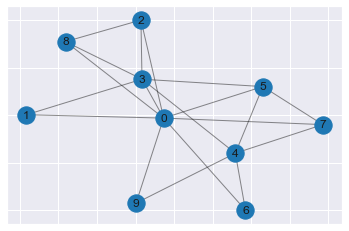

In [6]:
G = nx.random_graphs.erdos_renyi_graph(10, 0.5)

draw_graph(G)

W = nx.adjacency_matrix(G)

print(W.todense())

In [7]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
print('degree matrix:')
print(D)# laplacian matrix
L = D - W
print('laplacian matrix:')
print(L)

degree matrix:
[[8 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 2]]
laplacian matrix:
[[ 8 -1 -1 -1  0 -1 -1 -1 -1 -1]
 [-1  2  0 -1  0  0  0  0  0  0]
 [-1  0  3 -1  0  0  0  0 -1  0]
 [-1 -1 -1  6 -1 -1  0  0 -1  0]
 [ 0  0  0 -1  5 -1 -1 -1  0 -1]
 [-1  0  0 -1 -1  4  0 -1  0  0]
 [-1  0  0  0 -1  0  2  0  0  0]
 [-1  0  0  0 -1 -1  0  3  0  0]
 [-1  0 -1 -1  0  0  0  0  3  0]
 [-1  0  0  0 -1  0  0  0  0  2]]


In [8]:
e, v = np.linalg.eig(L)# eigenvalues
print('eigenvalues:')
print(e)# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[9.211 7.184 0.000 5.682 4.280 1.438 2.204 4.000 2.000 2.000]
eigenvectors:
[[0.898 -0.185 0.316 -0.238 0.045 0.036 0.015 -0.000 -0.000 0.000]
 [-0.096 0.194 0.316 -0.004 0.107 0.401 0.121 0.000 0.815 -0.320]
 [-0.096 0.194 0.316 -0.004 0.107 0.401 0.121 -0.707 -0.407 0.160]
 [-0.205 -0.820 0.316 0.254 -0.288 0.189 -0.039 0.000 -0.000 -0.000]
 [0.190 0.335 0.316 0.789 -0.212 -0.271 -0.100 0.000 0.000 -0.000]
 [-0.140 0.240 0.316 -0.458 -0.648 -0.102 -0.428 0.000 0.000 -0.000]
 [-0.151 -0.029 0.316 -0.150 0.073 -0.419 0.416 -0.000 -0.048 -0.651]
 [-0.153 -0.093 0.316 -0.035 0.637 -0.216 -0.644 -0.000 0.000 -0.000]
 [-0.096 0.194 0.316 -0.004 0.107 0.401 0.121 0.707 -0.407 0.160]
 [-0.151 -0.029 0.316 -0.150 0.073 -0.419 0.416 0.000 0.048 0.651]]


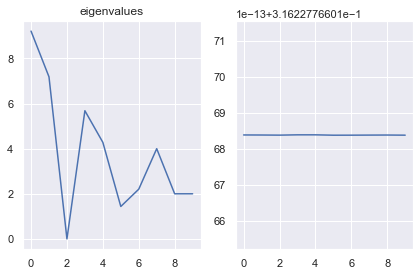

In [9]:
fig = plt.figure()

ax1 = plt.subplot(121)
plt.plot(e)
ax1.title.set_text('eigenvalues')

i = np.where(e < 10e-6)[0]
ax2 = plt.subplot(122)
plt.plot(v[:, i[0]])

fig.tight_layout()
plt.show()

## KNN

In [ ]:
#2D spectral clustering - Not Scaled
X = hotel[['Customer Satisfaction Rating', 'AD Revenues Weighted']].to_numpy()
spectral_2d = SpectralClustering(n_clusters=8, 
                                 assign_labels="discretize", 
                                 affinity='nearest_neighbors',
                                 n_neighbors=10,
                                 random_state=0, 
                                 n_init=15).fit(X)

In [ ]:
# Experiment - Affinity_Matrix
X = hotel[['Customer Satisfaction Rating','AD Revenues Weighted']].to_numpy()

spectral_2d = SpectralClustering(n_clusters=5, 
                                 assign_labels="nearest_neighbour", 
                                 random_state=0,
                                 # n_components=10,
                                 n_init=10,
                                 #n_jobs=-1
                                ).fit(X).affinity_matrix_
spectral_2d

In [ ]:
# 3D spectral clustering - n_neighbord 7
hotel['ADR - Scaled'] = minmax_scale(hotel['ADR'])
hotel['Expenditures - Scaled'] = minmax_scale(hotel['Additional Expenditures']/hotel['Nights'])
X = hotel[['Customer Satisfaction Rating - Scaled','ADR - Scaled','Expenditures - Scaled']].to_numpy()
spectral_2d = SpectralClustering(n_clusters=6, 
                                 assign_labels="discretize", 
                                 affinity='nearest_neighbors',
                                 n_neighbors=10,
                                 random_state=0, 
                                 n_init=15).fit(X)

hotel['Cluster2'] = spectral_2d.labels_

# Graphical representation
"""fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_hotel2 = ax.scatter(hotel['Customer Satisfaction Rating - Scaled'], 
                            hotel['ADR - Scaled'],
                            hotel['Expenditures - Scaled'],
                            c=spectral_2d.labels_, 
                            s=5)"""

## DBASCAN

In [ ]:
"""cluster_scanned = DBSCAN(eps=0.05, min_samples=16)
X = hotel_opt_expand_person[['Rating_adj','ADR_person']].to_numpy()

cluster_predicted = cluster_scanned.fit(X)
hotel_opt_expand_person['Cluster'] = cluster_predicted.labels_
hotel_opt_expand_person['Cluster'].value_counts()"""

In [ ]:
cluster_scanned = DBSCAN(eps=0.1, min_samples=6)
X = hotel_persons[['Customer Satisfaction Rating - Scaled','Daily Revenues per Person - Scaled']].to_numpy()

cluster_predicted = cluster_scanned.fit(X)
#hotel_opt_expand_person['Cluster'] = cluster_predicted.labels_
#hotel_opt_expand_person['Cluster'].value_counts()

# Graphical representation
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter_dbscan = ax.scatter(hotel_persons['Customer Satisfaction Rating - Scaled'], 
                            hotel_persons['Daily Revenues per Person - Scaled'],
                            c=cluster_predicted.labels_, 
                            s=1)
#hotel_opt_expand_person['Cluster'].value_counts()

In [ ]:
cluster_scanned = DBSCAN(eps=0.1, min_samples=6)
cluster_predicted = cluster_scanned.fit_predict(X)
# hotel_persons['Cluster2'] = cluster_predicted
# hotel_persons['Cluster2'].value_counts()

## Evaluating the K-means model

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

    Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

    Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.


In [2]:
# Run the Kmeans algorithm and get the index of data points clusters

sse = []
list_k = list(range(1, 10))

for k in list_k:
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans.fit(hotel3_sample[['Revenues_scalato','Rating_scalato']])
    sse.append(kmeans.inertia_)
    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

NameError: name 'KMeans' is not defined

# Part 3: Functions

In [ ]:
## RandomForest Hyperparameters Optimization: Randomized Search
## Exxcluded because I cannot control it
NUM_LOOPS_RANDOM = 3
N_ITER = 7
random_params_rev_random_forest = random_forest_params(n_estimators=[45, 35, 21],
                                                    max_depth=[5, 9, 15])

for i in range(NUM_LOOPS_RANDOM):
    randomized_optimal_params_rev_rf = RandomizedSearchCV(
        RandomForestRegressor(),
        random_params_rev_random_forest,
        scoring='neg_mean_squared_error',
        cv=5,
        n_iter=N_ITER)

    randomized_optimal_params_rev_rf.fit(X_revenues, Y_revenues)
    print(randomized_optimal_params_rev_rf.best_params_)
    
# NOTES: max_depth is usually 9, but num_estimators varier from 21 to 35, every time. 
# I focus on 9 and test more n_estimators, and higher CV than 3
# Now among [45, 35, 21], 2times 45 and 1time 35. I will increase

In [ ]:
## 

def best_model_pipeline(X, Y, pipeline, params_range, cv, scoring='neg_mean_squared_error'):
    
    optimal_model = GridSearchCV(pipeline,
                                params_range,
                                scoring=scoring,
                                cv=cv,
                                refit=True)  # when there is a list in scoring, it needs an explicit one
    
    result = optimal_model.fit(X, Y)
    best_params = result.best_estimator_  # result.best_params_ needed when refit=False
    
    dict_parameters_pipeline = {}
    for param in params_range:  # list of parameters
        dict_parameters_pipeline[str(param)] = best_params.get_params()[str(param)]
    
    
# PROPOSAL: BLOCK for updating best_params]
    for value in dict_parameters_pipeline:
        data_to_update = {str(value): params_range[value]}
        params_range.update(data_to_update)
    
    params_range = ModelsParameters(params_range).create_ranges_rf(prefix_pipeline='rf__')
    print('Below are the best params')
    print(params_range)
        
    return result, dict_parameters_pipeline #params_range
